# Optimal rocket trajectory

A rocket of mass $m$ is launched at sea level and has to reach an altitude $H$ within time $T$ . Let $y(t)$ be the altitude of the rocket at time $t$ and $u(t)$ the force acting on the rocket at time $t$ in the vertical direction. Assume $u(t)$ may not evceed a given value $b$, that the rocket has constant mass $m$ throughout, and that the gravity acceleration $g$ is constant in the interval $[0,H]$. 

The equation of motion of the rocket is:
$$
\forall t \in [0,T]\quad m\frac{\partial^2 y(t)}{\partial t^2}+mg=u(t). $$
 At time 0 (resp. T), the rocket must be at height 0 (resp. H); velocity at time 0 is 0, so $y(0) = v(0) = 0$, $y(T) = H$. The force acting on the rocket must not evceed $b$, so $|u(t)| \leq b$ for each $t \in [0,T]$. We must determine $u(t)$ so that the energy use is minimum. Our objective function is thus $E = \int_0^T |u(t)|dt$. This gives a nonlinear problem with time dependency:
$$
\begin{array}{l}
\min \int_0^T |u(t)|dt \\
\forall t \in [0,T]\quad |u(t)| \leq b \\
\forall t \in [0,T]\quad m\frac{\partial^2 y(t)}{\partial t^2}+mg=u(t) \\
y(0) = 0  \\
y(T) = H  \\
v(0) = 0.
\end{array}
$$

In [1]:
import gamspy as gp
from gamspy import Sum

import sys
import numpy as np

cont = gp.Container()

In [2]:
# Data of problem
T = 60 # time horizon
H = 23000 # height to reach
m = 214.0 # mass of rocket
b = 10000 # limit on force
g = 9.8 # gravity acceleration
n = 240 # number of time intervals

We approvimate the integral using the trapezoidal rule (see https://en.wikipedia.org/wiki/Trapezoidal_rule).

In [3]:
# Enter your model here
intervals = cont.addSet('intervals',records=range(0, 241))
deltaT = cont.addParameter('deltaT', description='set interval width deltaT to be T/n')
deltaT[:] = T / n

y = cont.addVariable('y', domain = intervals, description='position')
v = cont.addVariable('v', domain = intervals, description='velocity')
u = cont.addVariable('u', domain = intervals, description='force')
split1 = cont.addVariable('split1', 'positive', domain=intervals)
split2 = cont.addVariable('split2', 'positive', domain=intervals)
# total_energy = cont.addVariable('total_energy', 'free')

y.fx['0'] = 0
y.fx[str(n)] = H
v.fx['0'] = 0

position = cont.addEquation('pos_update', domain=intervals)
position[intervals].where[~intervals.last] = (y[intervals.lead(1)] == y[intervals] + deltaT*v[intervals])

velocity = cont.addEquation('vel_update', domain=intervals)
velocity[intervals].where[~intervals.last] = (v[intervals.lead(1)] == v[intervals] + deltaT*(u[intervals] / m - g))

force = cont.addEquation('force_update', domain=intervals)
force[intervals] = u[intervals] == split1[intervals] - split2[intervals]

force_bound = cont.addEquation('u_bound', domain=intervals)
force_bound[intervals] = split1[intervals] + split2[intervals] <= b

# energy = cont.addEquation('energy')
# energy[:] = total_energy == (deltaT / 2 * (Sum(intervals.where[~intervals.last], split1[intervals] + split2[intervals]) +
#                           Sum(intervals.where[~intervals.first], split1[intervals] + split2[intervals])))

rocket = cont.addModel('rocket',
    equations=cont.getEquations(),
    problem=gp.Problem.LP,
    sense=gp.Sense.MIN,
    objective=(deltaT / 2 * (Sum(intervals.where[~intervals.last], split1[intervals] + split2[intervals]) +
                          Sum(intervals.where[~intervals.first], split1[intervals] + split2[intervals])))
)

rocket.solve()


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,167528.627906977,963,1206,LP,CPLEX,0.028


Now run real model.   

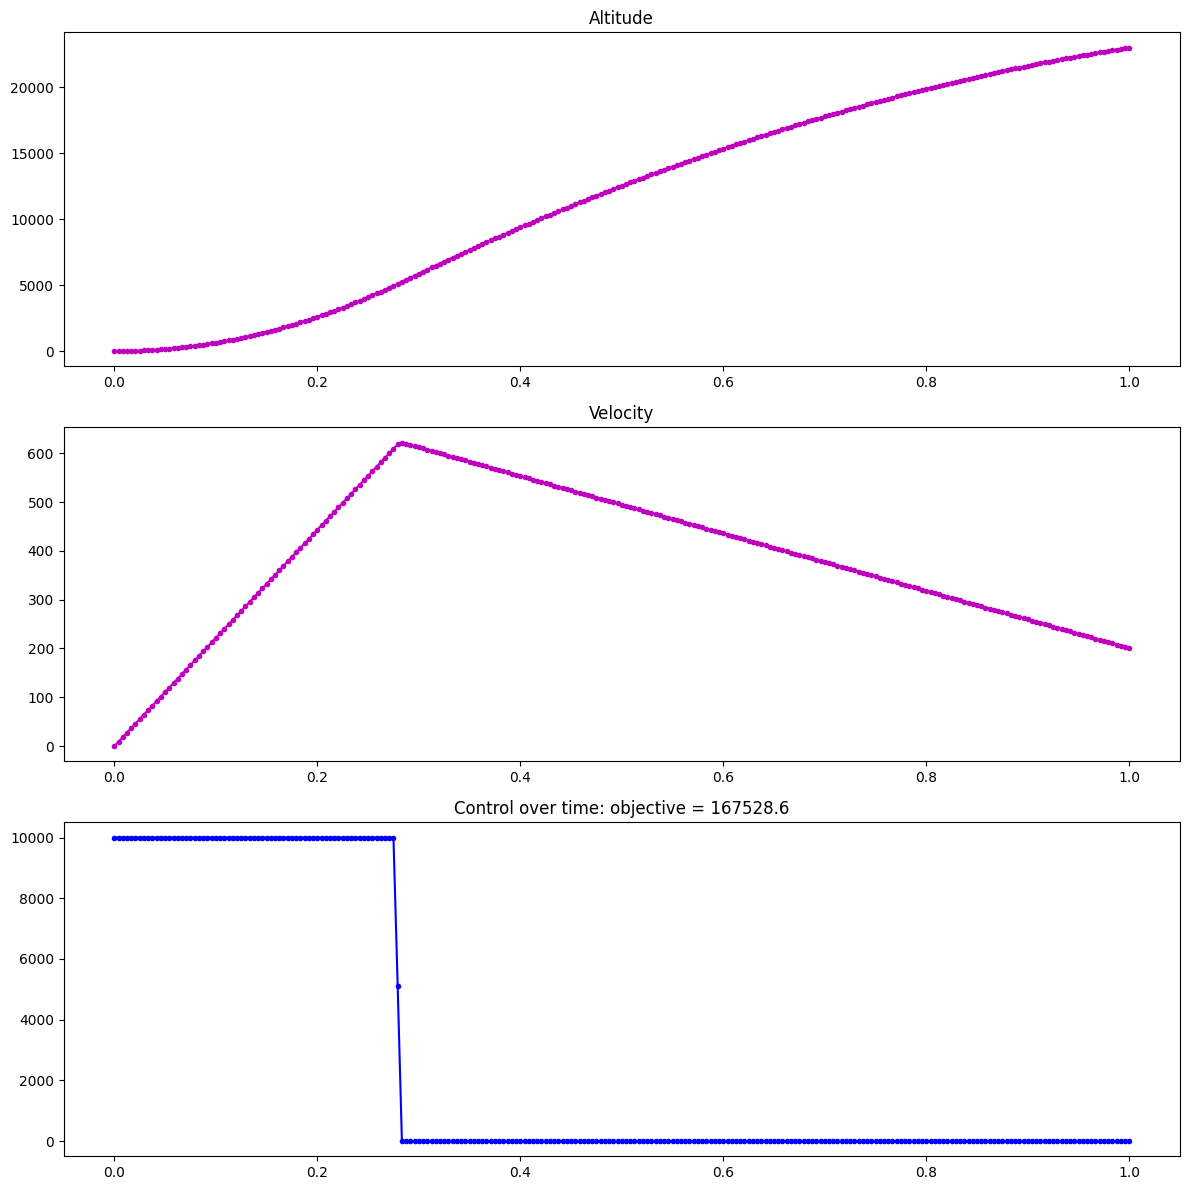

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_traj(cost,y,v,u):

    tval = [ind/n for ind in range(0,n+1)]
    fig, ax = plt.subplots(nrows=3,figsize=(12,12))
    # plot the y data
    ax[0].plot(tval,y.toDense(),'m.-')
    ax[0].set_title('Altitude')
    ax[1].plot(tval,v.toDense(),'m.-')
    ax[1].set_title('Velocity')
    ax[2].plot(tval,u.toDense(),"b.-")
    ax[2].set_title(f"Control over time: objective = {cost:.1f}")
    fig.tight_layout();

rocket.solve(solver="cplex",output=None)
plot_traj(rocket.objective_value,y,v,u)